Cropped frames scanned : 87
Frames with pose found : 86
Saved images to        : C:\Users\yenul\PycharmProjects\YOLO_speed_tracker\mediapipe detection and get scetch\exported_frames_pose_out


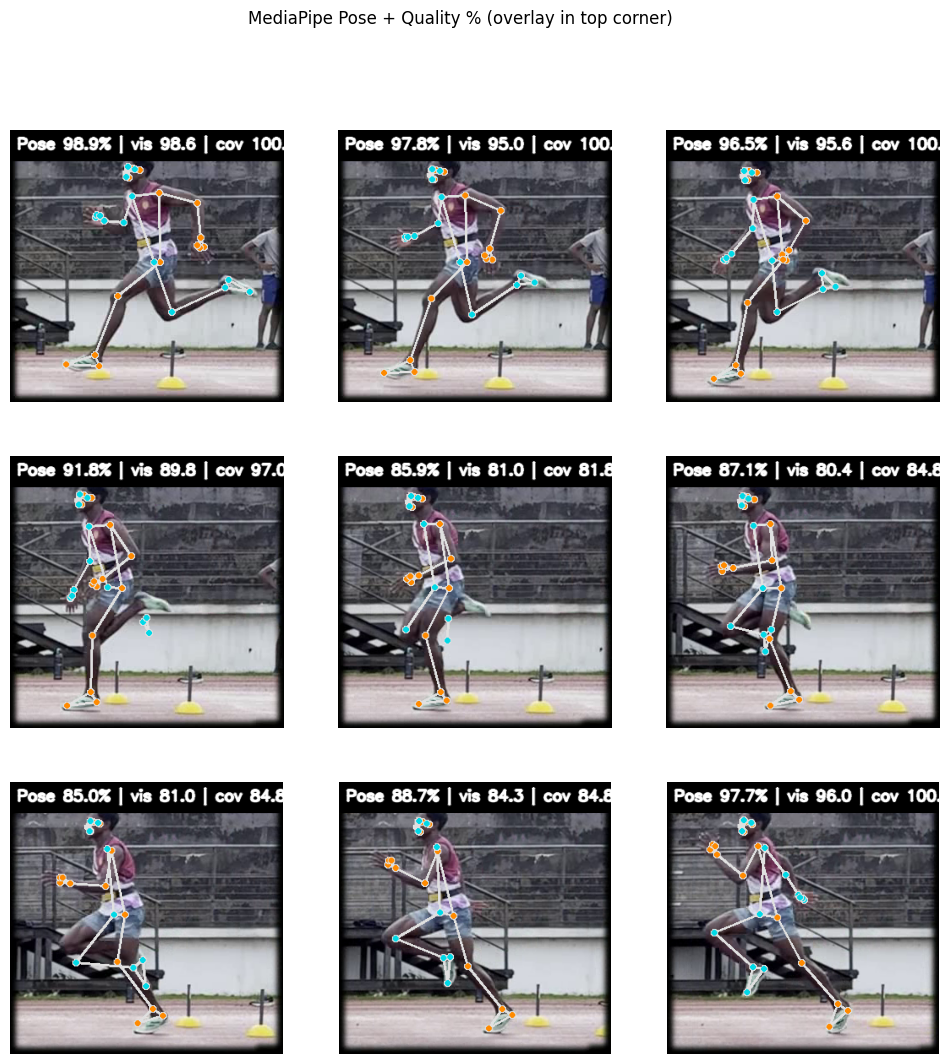

In [1]:
# === MEDIAPIPE POSE ON CROPPED FRAMES + QUALITY % OVERLAY IN TOP CORNER ===
import os, math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

try:
    import mediapipe as mp
except ImportError as e:
    raise ImportError("MediaPipe not found. Please run: pip install mediapipe") from e

# ------------------- SETTINGS -------------------
CROPPED_DIR = "exported_frames_cropped2"   # input frames (cropped person images)
OUT_DIR     = "exported_frames_pose_out"   # where to save overlaid outputs
VIS_THR     = 0.5                          # visibility threshold for coverage %
ALPHA_EMA   = 0.2                          # temporal smoothing factor
SHOW_PREVIEW = True
MAX_PREVIEW  = 9
INFO_POS     = "top-left"                  # "top-left" or "top-right"

os.makedirs(OUT_DIR, exist_ok=True)

# ------------------- MEDIAPIPE INIT -------------------
mp_pose  = mp.solutions.pose
mp_draw  = mp.solutions.drawing_utils
mp_style = mp.solutions.drawing_styles

pose = mp_pose.Pose(
    static_image_mode=True,        # processing still images
    model_complexity=1,
    enable_segmentation=True,      # needed for on-body %
    min_detection_confidence=0.5
)

# ------------------- QUALITY SCORING -------------------
def pose_quality_scores(results, vis_thresh=0.5, ema_prev=None, alpha=0.2):
    """
    Returns dict with: present, visibility_pct, coverage_pct, onbody_pct, final_pct, temporal_pct
    Blends visibility, coverage, and (if present) on-body % into 'final_pct'.
    """
    if not results.pose_landmarks:
        temporal_pct = ema_prev if ema_prev is not None else 0.0
        return {"present": False, "visibility_pct": 0.0, "coverage_pct": 0.0,
                "onbody_pct": 0.0, "final_pct": 0.0, "temporal_pct": temporal_pct}, ema_prev

    lm = results.pose_landmarks.landmark
    v = np.array([np.clip(p.visibility, 0.0, 1.0) for p in lm], dtype=np.float32)
    visibility_pct = 100.0 * float(v.mean())
    coverage_pct   = 100.0 * float((v >= vis_thresh).mean())

    onbody_pct = 0.0
    if getattr(results, "segmentation_mask", None) is not None:
        mask = results.segmentation_mask
        h, w = mask.shape
        xs = np.clip((np.array([p.x for p in lm]) * w).astype(int), 0, w-1)
        ys = np.clip((np.array([p.y for p in lm]) * h).astype(int), 0, h-1)
        onbody_pct = 100.0 * float(mask[ys, xs].mean())

    temporal_pct = visibility_pct if ema_prev is None else (1 - alpha) * ema_prev + alpha * visibility_pct

    if getattr(results, "segmentation_mask", None) is not None:
        w_vis, w_cov, w_onb = 0.4, 0.3, 0.3
    else:
        w_vis, w_cov, w_onb = 0.6, 0.4, 0.0

    final_pct = (w_vis * visibility_pct + w_cov * coverage_pct + w_onb * onbody_pct) / (w_vis + w_cov + w_onb + 1e-8)

    return {
        "present": True,
        "visibility_pct": visibility_pct,
        "coverage_pct": coverage_pct,
        "onbody_pct": onbody_pct,
        "final_pct": final_pct,
        "temporal_pct": temporal_pct
    }, temporal_pct

def skeleton_fit_pct(results):
    if not (results.pose_landmarks and getattr(results, "segmentation_mask", None) is not None):
        return 0.0
    lm = results.pose_landmarks.landmark
    mask = results.segmentation_mask
    h, w = mask.shape
    skel = np.zeros_like(mask, dtype=np.uint8)
    for a, b in mp_pose.POSE_CONNECTIONS:
        pa, pb = lm[a], lm[b]
        ax, ay = int(pa.x * w), int(pa.y * h)
        bx, by = int(pb.x * w), int(pb.y * h)
        cv2.line(skel, (ax, ay), (bx, by), 1, 2)
    body = (mask >= 0.5).astype(np.uint8)
    overlap = (skel & body).sum()
    total   = skel.sum() if skel.sum() else 1
    return 100.0 * overlap / total

# nice label in a corner
def draw_info_label(img, text, pos="top-left"):
    font = cv2.FONT_HERSHEY_SIMPLEX
    scale, thick = 0.6, 2
    pad = 8

    (tw, th), baseline = cv2.getTextSize(text, font, scale, thick)
    H, W = img.shape[:2]
    if pos == "top-right":
        x = W - pad - tw
        y = pad + th
    else:  # top-left
        x = pad
        y = pad + th

    # background box
    x1, y1 = x - pad, y - th - pad
    x2, y2 = x + tw + pad, y + baseline + pad
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(W-1, x2), min(H-1, y2)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 0), -1)
    # text
    cv2.putText(img, text, (x, y), font, scale, (255, 255, 255), thick, cv2.LINE_AA)
    return img

# ------------------- PROCESS ALL IMAGES -------------------
files = sorted(Path(CROPPED_DIR).glob("*.png"))
if not files:
    pose.close()
    raise RuntimeError(f"No cropped frames found in {CROPPED_DIR}.")

previews = []
processed = 0
ema = None

for idx, fp in enumerate(files):
    img_bgr = cv2.imread(str(fp))
    if img_bgr is None:
        continue

    rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    res = pose.process(rgb)

    if res.pose_landmarks:
        mp_draw.draw_landmarks(
            img_bgr, res.pose_landmarks, mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_style.get_default_pose_landmarks_style()
        )

    scores, ema = pose_quality_scores(res, vis_thresh=VIS_THR, ema_prev=ema, alpha=ALPHA_EMA)
    fit_pct = skeleton_fit_pct(res) if getattr(res, "segmentation_mask", None) is not None else 0.0

    if scores["present"]:
        processed += 1
        label = (f"Pose {scores['final_pct']:.1f}% | vis {scores['visibility_pct']:.1f} | "
                 f"cov {scores['coverage_pct']:.1f} | on {scores['onbody_pct']:.1f} | fit {fit_pct:.1f}")
    else:
        label = "Pose not found"

    # draw label in chosen corner (no extra bar, directly on image)
    img_bgr = draw_info_label(img_bgr, label, pos=INFO_POS)

    # save
    out_fp = Path(OUT_DIR) / fp.name
    cv2.imwrite(str(out_fp), img_bgr)

    if len(previews) < MAX_PREVIEW:
        previews.append(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))

pose.close()

print(f"Cropped frames scanned : {len(files)}")
print(f"Frames with pose found : {processed}")
print(f"Saved images to        : {Path(OUT_DIR).resolve()}")

# ------------------- PREVIEW -------------------
if SHOW_PREVIEW and previews:
    cols = 3
    rows = math.ceil(len(previews) / cols)
    plt.figure(figsize=(12, rows * 4))
    for i, im in enumerate(previews, 1):
        plt.subplot(rows, cols, i)
        plt.imshow(im); plt.axis("off")
    plt.suptitle("MediaPipe Pose + Quality % (overlay in top corner)")
    plt.show()


Cropped frames scanned : 87
Frames with pose found : 87
Saved images to        : C:\Users\yenul\PycharmProjects\YOLO_speed_tracker\mediapipe detection and get scetch\exported_frames_pose_out_mv


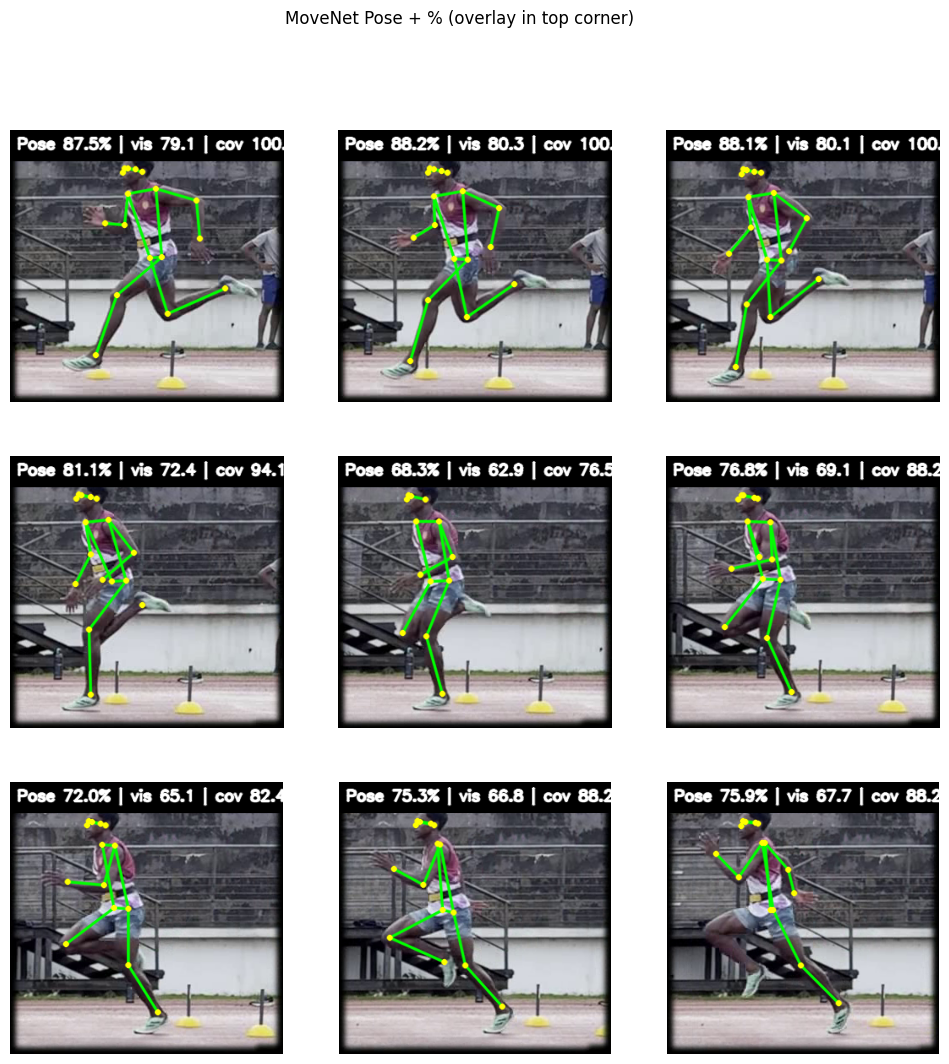

In [3]:
# === MOVENET (TFLite) ON CROPPED FRAMES + SKELETON + POSE % OVERLAY ===
import os, math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

try:
    import tensorflow as tf
except ImportError as e:
    raise ImportError("TensorFlow not found. Please run: pip install tensorflow") from e

# ------------------- SETTINGS -------------------
CROPPED_DIR   = "exported_frames_cropped2"     # input frames (cropped person images)
OUT_DIR       = "exported_frames_pose_out_mv"  # output folder
MODEL_PATH    = r"E:\DE CW\Lec_notes\4.tflite"  # <-- change to your .tflite path
SCORE_THR     = 0.5                            # kp score threshold for drawing/coverage
ALPHA_EMA     = 0.2                            # temporal smoothing factor
SHOW_PREVIEW  = True
MAX_PREVIEW   = 9
INFO_POS      = "top-left"                     # "top-left" or "top-right"

os.makedirs(OUT_DIR, exist_ok=True)

# ------------------- MOVENET / TFLITE INIT -------------------
interpreter = tf.lite.Interpreter(model_path=MODEL_PATH)
interpreter.allocate_tensors()
in_details  = interpreter.get_input_details()
out_details = interpreter.get_output_details()

# Expect input [1, H, W, 3]
INPUT_H, INPUT_W = int(in_details[0]["shape"][1]), int(in_details[0]["shape"][2])
INPUT_DTYPE = in_details[0]["dtype"]

def letterbox(img_bgr, target_w, target_h):
    """Resize with padding to keep aspect ratio. Returns padded RGB, scale, left, top."""
    h, w = img_bgr.shape[:2]
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(img_bgr, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    canvas = np.zeros((target_h, target_w, 3), dtype=np.uint8)
    left = (target_w - new_w) // 2
    top  = (target_h - new_h) // 2
    canvas[top:top+new_h, left:left+new_w] = resized
    rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
    return rgb, scale, left, top

def preprocess(img_bgr):
    rgb, scale, left, top = letterbox(img_bgr, INPUT_W, INPUT_H)
    x = rgb.astype(np.float32)
    # Match interpreter dtype
    if INPUT_DTYPE == np.float32:
        x = x / 255.0
    elif INPUT_DTYPE == np.uint8:
        x = x.astype(np.uint8)
    elif INPUT_DTYPE == np.int32:
        x = x.astype(np.int32)  # some TFLite variants expect int32 0..255
    x = np.expand_dims(x, axis=0)  # [1,H,W,3]
    return x, (scale, left, top)

def run_movenet(img_bgr):
    """Returns keypoints in original image coords and their scores."""
    x, (scale, left, top) = preprocess(img_bgr)
    interpreter.set_tensor(in_details[0]["index"], x)
    interpreter.invoke()
    out = interpreter.get_tensor(out_details[0]["index"])
    # Handle common shapes: [1,1,17,3] or [1,17,3]
    if out.ndim == 4:
        kps = out[0, 0, :, :]   # [17,3]
    else:
        kps = out[0, :, :]      # [17,3]
    # kps: (y, x, score) in 0..1 relative to the *letterboxed* tensor
    H_in, W_in = INPUT_H, INPUT_W
    ys = kps[:, 0] * H_in
    xs = kps[:, 1] * W_in
    scores = kps[:, 2]

    # Map back to original image coords (undo letterbox)
    H0, W0 = img_bgr.shape[:2]
    xs = (xs - left) / max(scale, 1e-6)
    ys = (ys - top)  / max(scale, 1e-6)
    xs = np.clip(xs, 0, W0 - 1)
    ys = np.clip(ys, 0, H0 - 1)
    return np.stack([xs, ys, scores], axis=1)  # [17,3]

# COCO-17 keypoint indices for MoveNet
# 0 nose; 1 L eye; 2 R eye; 3 L ear; 4 R ear; 5 L shoulder; 6 R shoulder; 7 L elbow; 8 R elbow;
# 9 L wrist; 10 R wrist; 11 L hip; 12 R hip; 13 L knee; 14 R knee; 15 L ankle; 16 R ankle
POSE_EDGES = [
    (5,7),(7,9), (6,8),(8,10), (5,6), (5,11),(6,12), (11,12),
    (11,13),(13,15), (12,14),(14,16),
    (0,1),(1,3), (0,2),(2,4)  # head
]

# ------------------- POSE SCORING (no segmentation) -------------------
def pose_quality_scores_movenet(kps, ema_prev=None, alpha=0.2, thr=SCORE_THR):
    """
    kps: [17,3] with (x,y,score). Returns dict + EMA.
    - visibility_pct = mean(score)*100
    - coverage_pct   = fraction(score>=thr)*100
    - final_pct      = 0.6*visibility + 0.4*coverage
    """
    if kps is None or len(kps) != 17:
        temporal = ema_prev if ema_prev is not None else 0.0
        return {"present": False, "visibility_pct": 0.0, "coverage_pct": 0.0,
                "final_pct": 0.0, "temporal_pct": temporal}, ema_prev

    s = np.clip(kps[:, 2], 0.0, 1.0)
    visibility_pct = 100.0 * float(s.mean())
    coverage_pct   = 100.0 * float((s >= thr).mean())
    temporal_pct   = visibility_pct if ema_prev is None else (1 - alpha) * ema_prev + alpha * visibility_pct
    final_pct      = 0.6 * visibility_pct + 0.4 * coverage_pct
    return {"present": True,
            "visibility_pct": visibility_pct,
            "coverage_pct": coverage_pct,
            "final_pct": final_pct,
            "temporal_pct": temporal_pct}, temporal_pct

# ------------------- DRAWING -------------------
def draw_skeleton(img, kps, score_thr=SCORE_THR):
    # lines
    for a, b in POSE_EDGES:
        if kps[a,2] >= score_thr and kps[b,2] >= score_thr:
            ax, ay = int(kps[a,0]), int(kps[a,1])
            bx, by = int(kps[b,0]), int(kps[b,1])
            cv2.line(img, (ax, ay), (bx, by), (0, 255, 0), 2, cv2.LINE_AA)
    # joints
    for i in range(17):
        if kps[i,2] >= score_thr:
            x, y = int(kps[i,0]), int(kps[i,1])
            cv2.circle(img, (x, y), 3, (0, 255, 255), -1, cv2.LINE_AA)
    return img

def draw_info_label(img, text, pos="top-left"):
    font = cv2.FONT_HERSHEY_SIMPLEX
    scale, thick = 0.6, 2
    pad = 8
    (tw, th), baseline = cv2.getTextSize(text, font, scale, thick)
    H, W = img.shape[:2]
    if pos == "top-right":
        x = W - pad - tw
        y = pad + th
    else:
        x = pad
        y = pad + th
    x1, y1 = x - pad, y - th - pad
    x2, y2 = x + tw + pad, y + baseline + pad
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(W-1, x2), min(H-1, y2)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,0), -1)
    cv2.putText(img, text, (x, y), font, scale, (255,255,255), thick, cv2.LINE_AA)
    return img

# ------------------- PROCESS ALL IMAGES -------------------
files = sorted(Path(CROPPED_DIR).glob("*.png"))
if not files:
    raise RuntimeError(f"No cropped frames found in {CROPPED_DIR}.")

previews, processed = [], 0
ema = None

for idx, fp in enumerate(files):
    img_bgr = cv2.imread(str(fp))
    if img_bgr is None:
        continue

    # Inference
    kps = run_movenet(img_bgr)

    # Draw skeleton
    if kps is not None and np.any(kps[:,2] > 0):
        img_bgr = draw_skeleton(img_bgr, kps, score_thr=SCORE_THR)

    # Scores + overlay
    scores, ema = pose_quality_scores_movenet(kps, ema_prev=ema, alpha=ALPHA_EMA, thr=SCORE_THR)
    if scores["present"]:
        processed += 1
        label = (f"Pose {scores['final_pct']:.1f}% | vis {scores['visibility_pct']:.1f} | "
                 f"cov {scores['coverage_pct']:.1f}")
    else:
        label = "Pose not found"
    img_bgr = draw_info_label(img_bgr, label, pos=INFO_POS)

    # Save
    out_fp = Path(OUT_DIR) / fp.name
    cv2.imwrite(str(out_fp), img_bgr)

    if len(previews) < MAX_PREVIEW:
        previews.append(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))

print(f"Cropped frames scanned : {len(files)}")
print(f"Frames with pose found : {processed}")
print(f"Saved images to        : {Path(OUT_DIR).resolve()}")

# ------------------- PREVIEW -------------------
if SHOW_PREVIEW and previews:
    cols = 3
    rows = math.ceil(len(previews) / cols)
    plt.figure(figsize=(12, rows * 4))
    for i, im in enumerate(previews, 1):
        plt.subplot(rows, cols, i)
        plt.imshow(im); plt.axis("off")
    plt.suptitle("MoveNet Pose + % (overlay in top corner)")
    plt.show()
